# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import json

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

## Download Model

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [8]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [9]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/home/ubuntu/inzamam/videoframes'
num_frames = len(os.listdir(PATH_TO_TEST_IMAGES_DIR)) - 1
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'frame{:06d}.jpg'.format(i)) for i in range(0, len(os.listdir(PATH_TO_TEST_IMAGES_DIR)) - 1) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [10]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

In [11]:
image = Image.open(TEST_IMAGE_PATHS[0])
(im_width, im_height) = image.size
image = Image.open(TEST_IMAGE_PATHS[145])
image = np.reshape(image, (1, im_height, im_width, 3))
output_dict = run_inference_for_single_image(image, detection_graph)

In [12]:
ind = np.where(output_dict["detection_classes"] == 1)[0]
bboxes = output_dict["detection_boxes"]
scores = output_dict["detection_scores"]
selected_bboxes =  bboxes[ind]
selected_scores = scores[ind]
scores = np.flip(np.sort(selected_scores))
top_5 = min(selected_scores)

In [13]:
def get_bboxes_orig(bboxes, scores, top_score):
    orig_bboxes = []
    for bbox, score in zip(bboxes, scores):
        if score >= top_score:
            ymin = bbox[0]
            xmin = bbox[1]
            ymax = bbox[2]
            xmax = bbox[3]

            (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                              ymin * im_height, ymax * im_height)

            bbox_orig = [left, top, right - left, bottom - top]
            orig_bboxes.append(list(map(int, bbox_orig)))
    return orig_bboxes

In [14]:
bboxes = get_bboxes_orig(selected_bboxes, selected_scores, top_5)

In [21]:
import cv2
def draw_bboxes(image, bboxes):
    for bbox,i in zip(bboxes, range(len(bboxes))):
#         image_copy = image.copy()
        x1, y1 = bbox[0], bbox[1]
        x2 = bbox[2] + bbox[0]
        y2 = bbox[3] + bbox[1]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
#         cv2.imwrite('bboxes/frame{:03d}.jpg'.format(i), image_copy)
    return image

In [52]:
def cnvrt_bboxes(bboxes):
    bbox_list = []
    for bbox in bboxes:
        x1, y1 = bbox[0], bbox[1]
        x2 = bbox[2] + bbox[0]
        y2 = bbox[3] + bbox[1]
        _bbox = [x1, y1, x2, y2]
        bbox_list.append(_bbox)
    return bbox_list

In [80]:
def non_max_suppression_slow(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y1)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]

        # loop over all indexes in the indexes list
        for pos in range(0, last):
            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)
#             print(w, h)

            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            overlap = float(w * h) / area[j]
#             print(overlap)
            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > overlapThresh:
                suppress.append(pos)

        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)

    # return only the bounding boxes that were picked
    return boxes[pick]

In [94]:
def non_max_suppression_fast(boxes, probs=None, overlapThresh=0.3):
    
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes are integers, convert them to floats -- this
    # is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")

    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and grab the indexes to sort
    # (in the case that no probabilities are provided, simply sort on the
    # bottom-left y-coordinate)
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = y2

    # if probabilities are provided, sort on them instead
    if probs is not None:
        idxs = probs

    # sort the indexes
    idxs = np.argsort(idxs)

    # keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the index value
        # to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of the bounding
        # box and the smallest (x, y) coordinates for the end of the bounding
        # box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have overlap greater
        # than the provided overlap threshold
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))

    # return only the bounding boxes that were picked
    return boxes[pick].astype("int")

In [81]:
image = cv2.cvtColor(cv2.imread(TEST_IMAGE_PATHS[145]), cv2.COLOR_BGR2RGB)
rec_image = draw_bboxes(image.copy(), bboxes)

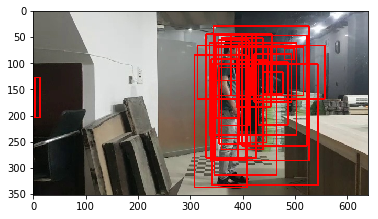

In [82]:
%matplotlib inline
plt.imshow(rec_image)

In [83]:
import cv2
def draw_nms_bboxes(image, bboxes):
    for bbox,i in zip(bboxes, range(len(bboxes))):
#         image_copy = image.copy()
        x1, y1 = bbox[0], bbox[1]
        x2, y2 = bbox[2], bbox[3]
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
#         cv2.imwrite('bboxes/frame{:03d}.jpg'.format(i), image_copy)
    return image

In [108]:
nms_bboxes = non_max_suppression_fast(np.asarray(cnvrt_bboxes(bboxes)), probs=selected_scores, overlapThresh=0.3)
nms_bboxes.shape

(4, 4)

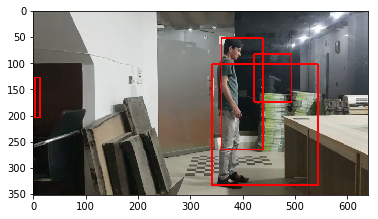

In [109]:
rec_image = draw_nms_bboxes(image.copy(), nms_bboxes.tolist())
plt.imshow(rec_image)

In [ ]:
ops = detection_graph.get_operations()
all_tensor_names = {output.name for op in ops for output in op.outputs}
tensor_dict = {}
for key in [
    'num_detections', 'detection_boxes', 'detection_scores',
    'detection_classes', 'detection_masks'
]:
  tensor_name = key + ':0'
  if tensor_name in all_tensor_names:
    tensor_dict[key] = detection_graph.get_tensor_by_name(
        tensor_name)
if 'detection_masks' in tensor_dict:
  # The following processing is only for single image
  detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
  detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
  # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
  real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
  detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
  detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
      detection_masks, detection_boxes, image.shape[1], image.shape[2])
  detection_masks_reframed = tf.cast(
      tf.greater(detection_masks_reframed, 0.5), tf.uint8)
  # Follow the convention by adding back the batch dimension
  tensor_dict['detection_masks'] = tf.expand_dims(
    detection_masks_reframed, 0)
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
sess = tf.Session(graph = detection_graph)

In [ ]:
def getcocodict(output_dict, image_path, im_height, im_width, batch_size):
    batch_image_list = []
    for i in range(batch_size):
        x = output_dict['detection_classes'][i]
        detection_boxes_output = output_dict['detection_boxes'][i]
        detection_scores_output =output_dict['detection_scores'][i]
        person_indices = np.where(x == 1)
        p_detection_boxes = detection_boxes_output[person_indices]
        p_detection_scores = detection_scores_output[person_indices]
        ymin = p_detection_boxes[np.where(max(p_detection_scores))][0][0]
        xmin = p_detection_boxes[np.where(max(p_detection_scores))][0][1]
        ymax = p_detection_boxes[np.where(max(p_detection_scores))][0][2]
        xmax = p_detection_boxes[np.where(max(p_detection_scores))][0][3]

        (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                          ymin * im_height, ymax * im_height)

        bbox = [left, top, right - left, bottom - top]
        image_dict = {}
        image_dict["image_id"] = image_path[i].split('/')[-1]
        image_dict["category_id"] = 1
        image_dict["bbox"] = bbox
        image_dict["score"] = float(max(p_detection_scores))
        batch_image_list.append(image_dict)
    return batch_image_list

In [ ]:
def getcocovaldict(image_path, im_height, im_width, batch_size):
    val_list = []
    batch_dict = {}
    for i in range(batch_size):
        image_dict = {'license': 3, 'file_name': '00000032.jpg', 'coco_url': 
                      'http://images.cocodataset.org/val2017/000000394940.jpg', 'height': 360, 'width': 640, 
                      'date_captured': '203213-11-24 13:47:05', 
                      'flickr_url': 'http://farm9.staticflickr.com/8227/8566023505_e9e9f997bc_z.jpg', 'id': 32}
        image_dict['file_name'] = image_path[i].split('/')[-1]
        image_dict['height'] = im_height
        image_dict['width'] = im_width
        image_dict['id'] = image_path[i].split('/')[-1]
        batch_dict[image_path[i].split('/')[-1]] = image_dict
    return batch_dict

In [ ]:
# image = Image.open(TEST_IMAGE_PATHS[0])
# (im_width, im_height) = image.size
# image_batch = np.zeros([32, im_height, im_width, 3], dtype=np.uint8)
# for i in range(32):
#     image = Image.open(TEST_IMAGE_PATHS[i])
#     image_batch[i,:,:,:] = load_image_into_numpy_array(image)
# output_dict = run_inference_for_single_image(image_batch, detection_graph)

def get_batch(batch_size, start, end, im_width, im_height):
    print("Start= ", start, "End= ", end)
    image_batch = np.zeros([batch_size, im_height, im_width, 3], dtype = np.uint8)
    for i, j in zip(range(start, end, 1), range(batch_size)):
        image = Image.open(TEST_IMAGE_PATHS[i])
        image_batch[j,:,:,:] = load_image_into_numpy_array(image)
    return image_batch

In [ ]:
print(len(TEST_IMAGE_PATHS))
print(len(TEST_IMAGE_PATHS) % 32)

In [ ]:
# batch_size = 32
# num_batch = len(TEST_IMAGE_PATHS) // batch_size
# for i in range(num_batch):
#     print("I = ", i, "Start = ", i * batch_size, "End = ", i * batch_size + batch_size)

In [ ]:
def parse_function(filename):
    image_string = tf.read_file(filename)

    # Don't use tf.image.decode_image, or the output shape will be undefined
    image = tf.image.decode_jpeg(image_string, channels=3)

    # This will convert to float values in [0, 1]
    image = tf.image.convert_image_dtype(image, tf.uint8)
    return image

batch_size = 128

dataset = tf.data.Dataset.from_tensor_slices((TEST_IMAGE_PATHS))
dataset = dataset.map(parse_function, num_parallel_calls=4)
dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(1)

iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()
graph_2 = tf.Graph()
sess2 = tf.Session()
i = 0
while True:
    i = i + 1
    try:
        elem = sess2.run(next_element)
        output_dict = sess.run(tensor_dict, feed_dict = {image_tensor: elem})
    except tf.errors.OutOfRangeError:
        print("End of training dataset.")
        break
    if i == 1:
        break

In [ ]:
print(len(output_dict["detection_classes"]))

In [ ]:
%matplotlib inline
plt.imshow(elem[15
                ,:,:,:])
plt.show()

In [ ]:
image = Image.open(TEST_IMAGE_PATHS[0])
(im_width, im_height) = image.size
batch_size = 32
num_batch = len(TEST_IMAGE_PATHS) // batch_size
detection_list = []
valimage_dict = {}
for i in range(num_batch):
    output_dict = run_inference_for_single_image(get_batch(start = i * batch_size, batch_size = batch_size,
                                                           end = i * batch_size + batch_size, im_width=im_width, im_height=im_height),
                                                 detection_graph)
    image_names = TEST_IMAGE_PATHS[i * batch_size:i * batch_size + batch_size]
    detection_list.extend(getcocodict(output_dict, image_names, im_height, im_width, batch_size=batch_size))
    valimage_dict.update(getcocovaldict(image_names, im_height, im_width, batch_size))


if len(TEST_IMAGE_PATHS) % batch_size != 0:
    remaining_batch = len(TEST_IMAGE_PATHS) % batch_size
    output_dict = run_inference_for_single_image(get_batch(start = (i + 1) * batch_size, end = (i + 1) * batch_size + remaining_batch,
                                                          im_width=im_width, im_height=im_height, batch_size= remaining_batch),
                                                detection_graph)
    image_names = TEST_IMAGE_PATHS[(i + 1) * batch_size:(i + 1) * batch_size + remaining_batch]
    detection_list.extend(getcocodict(output_dict, image_names, im_height, im_width, batch_size=remaining_batch))
    valimage_dict.update(getcocovaldict(image_names, im_height, im_width, remaining_batch))

In [ ]:
with open('human_detection.json', 'w') as outfile:
    json.dump(detection_list, outfile)

with open('valimage_dict.json', 'w') as outfile:
    json.dump(valimage_dict, outfile)

In [ ]:
getcocovaldict(image_names, im_height, im_width, batch_size)

In [ ]:
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [ ]:
%matplotlib inline
image = Image.open(TEST_IMAGE_PATHS[32])
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
plt.figure(figsize=IMAGE_SIZE)
plt.imshow(image_np)

In [ ]:
print(output_dict)

In [ ]:
print(getcocodict(output_dict, TEST_IMAGE_PATHS[32]))

In [ ]:
print(single_image_dict)

In [ ]:
import pycocotools


In [ ]:
import json
with open('data.json', 'w') as outfile:
    json.dump([single_image_dict], outfile)